<a href="https://colab.research.google.com/github/guptaShourya/DiabetesDetection/blob/main/DiabetesDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #data visualisation
import seaborn as sns #data visualisation
from google.colab import drive #drive
drive.mount('/content/drive') #attach google drive
#!pip install dataprep 
#!pip install datawig
import datawig # to impute missing values
sns.set()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
path = '/content/drive/My Drive/ML sem-5/Diabetes detection/data.csv'
# import data
data = pd.read_csv(path)

In [77]:
data.head(10) #display top 10 rows

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [78]:
# number of rows and columns in dataset
print("Data has {} rows, {} columns".format(data.shape[0], data.shape[1]))

Data has 768 rows, 9 columns


In [79]:
#number of nulls in dataset
print("Data has {} null values".format(data.isnull().any().sum()))

Data has 0 null values


In [80]:
# Statistical overview of data
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [81]:
# brief description of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


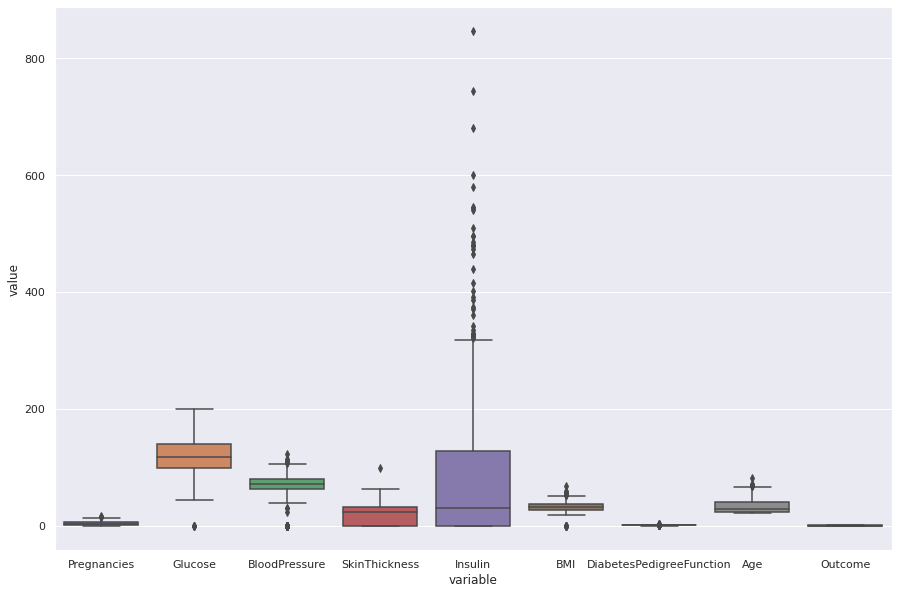

In [82]:
f, ax = plt.subplots(figsize = (15, 10)) # set size of the plot

sns.boxplot(x = "variable", y = "value", data = pd.melt(data), ax = ax) # use box plot to visualize outliers
plt.show() # display plot

In [83]:
def handleOutliers(data):
  Q1 = data.quantile(0.25) # calculate first quantile
  Q3 = data.quantile(0.75) # calculate third quantile
  IQR1 = Q3-Q1 # calculate inter quartile range

  data_c = data[~((data < (Q1-1.5*IQR1))|(data > (Q3+1.5*IQR1))).any(axis = 1)] # initialise data w/o outliers (drop outliers)

  print('Data loss is {}%'.format(((len(data) - len(data_c))/len(data))*100)) # report data loss
  return data_c.reset_index(drop = True)

In [84]:
data = handleOutliers(data) # drop outliers

Data loss is 16.796875%


In [85]:
def countMissing(data, col):
  return len(data[data[col] == 0]) # return count of missing values in column col

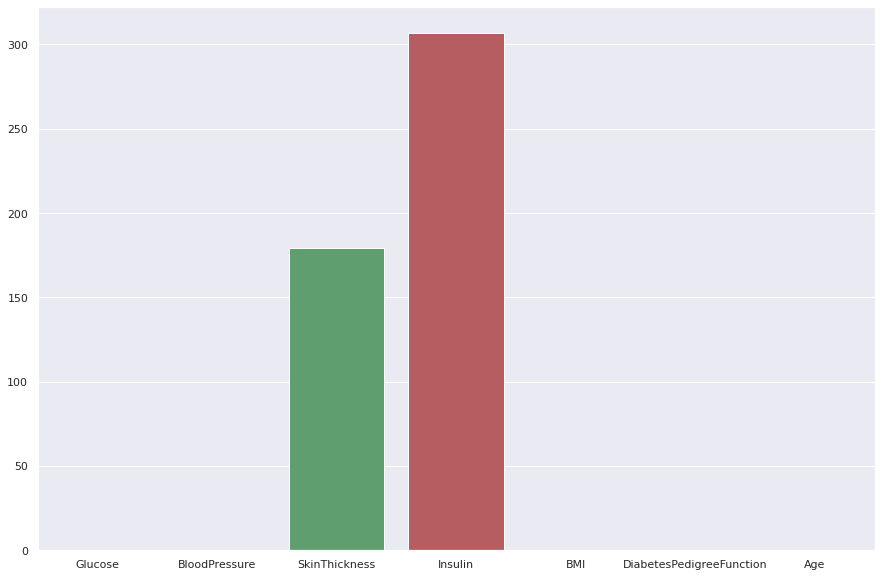

In [86]:
cols = list(data.columns)[1:-1] # columns check for missing values
missing_counts = [] # count of missing values

# for each column in columns
for col in cols:
  missing_counts.append(countMissing(data, col))

f, ax = plt.subplots(figsize = (15, 10)) # set size of the plot

sns.barplot(x = cols, y = missing_counts) # plot bar plot
plt.show() # display plot

In [87]:
# function to impute missing values in a given column
def impute(data, input_columns, column):
  #using simple imputer method
  imputer = datawig.SimpleImputer(
      input_columns = ip_columns, # use ip_columns for imputation
      output_column = column
  )

  #fit data
  imputer.fit(data[data[column]!=0])

  # impute missing values
  imputed = imputer.predict(data[data[column] == 0])

  index = imputed.index # index of imputed values
  # replace values in data
  for i in index:
    data.at[i, column] = imputed.at[i, (column + "_imputed")]
  
  return data

In [88]:
# columns to use as input to impute missing values of features
input_columns = list(np.array(data.columns)[(np.array(data.columns) != "SkinThickness") & (np.array(data.columns) != "Insulin")][:-1])

# impute missing values for SkinThickness column
data_c = impute(data, input_columns, "SkinThickness")

# impute missing values for Insulin column
data_c = impute(data, input_columns, "Insulin")

data = data_c

In [90]:
from sklearn import model_selection #train, test split

y = data['Outcome'] #target variable
X = data.drop('Outcome', axis = 1) #predictors

# split data into train (90%) and test(10%) set
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X, y, test_size = 0.1, random_state = 1)

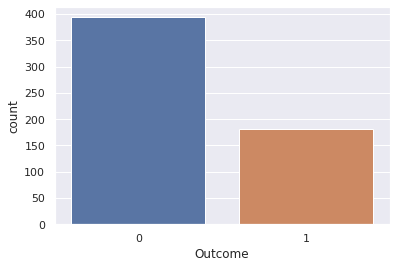

In [98]:
sns.countplot(x = Ytrain)

plt.show()

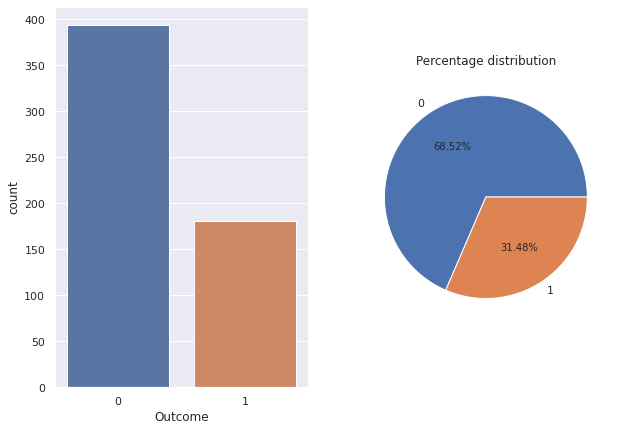

In [104]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 7)) # set up plot 

# visualise distribution in Ytrain

sns.countplot(x = Ytrain, ax = ax[0]) # plot bar plot

# plot a pie chart
ax[1].pie(x = Ytrain.value_counts().values, labels = Ytrain.value_counts().index, autopct = "%.2f%%")
ax[1].set_title("Percentage distribution") # set title

# display plots
plt.show()

In [106]:
from imblearn.over_sampling import SMOTE #to over sample minority class (outcome = 1)
from imblearn.under_sampling import RandomUnderSampler #to under sample majority class (outcome = 0)

#oversample considering 5 nearest neighbours such that |outcome=1|/|outcome=0| = 3/7
smote = SMOTE(sampling_strategy = 1, k_neighbors = 5, random_state = 9)
under = RandomUnderSampler(sampling_strategy = 1, random_state = 9) #undersample such that |outcome=1|/|outcome=0| = 0.5

Xtrain, Ytrain = smote.fit_resample(Xtrain, Ytrain) #apply oversampling
Xtrain, Ytrain = under.fit_resample(Xtrain, Ytrain) #apply undersampling

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [108]:
print('Class \tDistribution\n1\t', len(Ytrain[Ytrain==1])/len(Ytrain)*100, '% \n0\t', len(Ytrain[Ytrain==0])/len(Ytrain)*100, '%')

Class 	Distribution
1	 50.0 % 
0	 50.0 %
